In [113]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import json
from collections import Counter

# Training data

In [114]:
with open('image.json') as f:
    data = json.load(f)
    
size = 28
ldata = []
ydata = []
for zurag in data['images']:
    img = cv2.imread("smiling/"+zurag['name'],0)
    
    img = cv2.resize(img,(size,size))
  
    ldata.append(img.flatten())
    ydata.append(int(zurag['smile']))
print(len(ldata))
print(ydata)

88
[5, 5, 4, 5, 4, 4, 4, 4, 4, 2, 4, 4, 5, 4, 3, 5, 4, 4, 5, 4, 4, 4, 5, 4, 4, 3, 4, 4, 5, 4, 4, 3, 4, 5, 5, 3, 4, 4, 3, 4, 4, 4, 4, 5, 4, 3, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]


In [115]:
X = torch.tensor(ldata)
Y = torch.tensor(ydata)

In [116]:
print(X.shape)
print(Y.shape)

torch.Size([88, 784])
torch.Size([88])


In [117]:
train_x = X

train_y = Y


print(train_x.shape)

print(train_y.shape)

torch.Size([88, 784])
torch.Size([88])


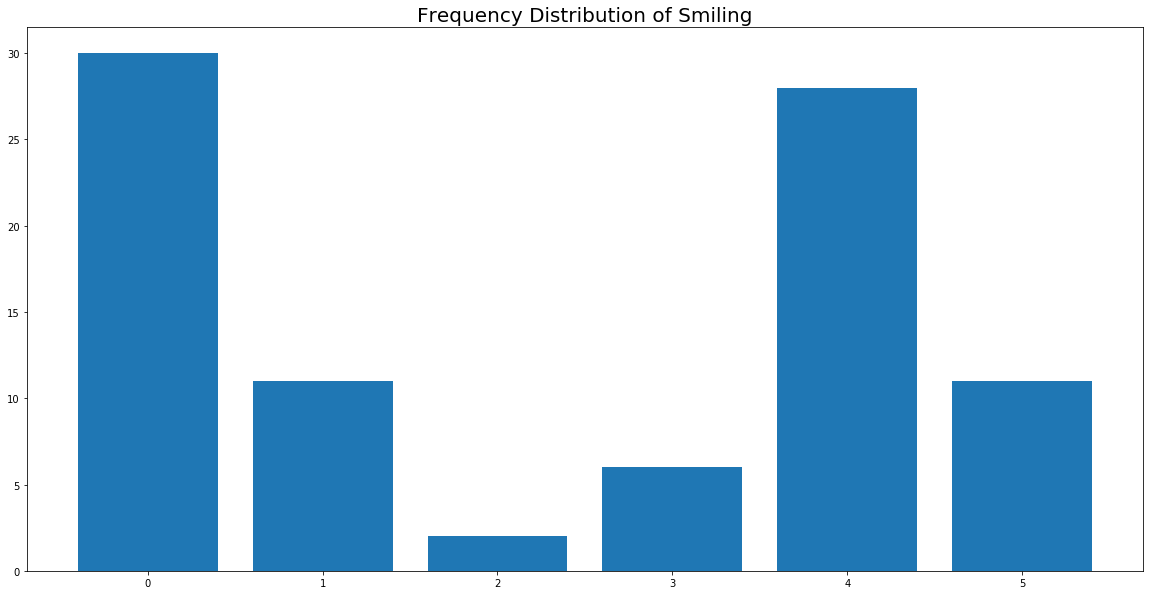

In [118]:
z = dict(Counter(list(ydata)))
labels = z.keys()
frequencies = [z[i] for i in labels]

plt.figure(figsize = (20, 10))
plt.bar(labels, frequencies)
plt.title('Frequency Distribution of Smiling', fontsize = 20)
plt.show()

In [119]:
def one_hot_encode(y):
    return np.eye(6)[y]
y_encoded = one_hot_encode(train_y)
print('Shape of y after encoding:', y_encoded.shape)
train_y=y_encoded

Shape of y after encoding: (88, 6)


# Test data

In [120]:
with open('test.json') as g:
    datatest = json.load(g)
    
size = 28
ldata = []
ydata = []
for zurag in datatest['test']:
    img = cv2.imread("test/"+zurag['name'],0)
    
    img = cv2.resize(img,(size,size))
  
    ldata.append(img.flatten())
    ydata.append(int(zurag['smile']))
print(len(ldata))
print(ydata)
X = torch.tensor(ldata)
Y = torch.tensor(ydata)
test_x = X

test_y = Y


print(test_x.shape)

print(test_y.shape)

17
[0, 5, 4, 5, 4, 4, 3, 1, 1, 5, 2, 0, 3, 4, 0, 5, 4]
torch.Size([17, 784])
torch.Size([17])


# Building CNN

In [121]:
learning_rate = 0.001
epochs = 100
batch_size = 128
display_step = 100
classes=6
inputs= 784
dropout = 0.75
# Placeholders
X1 = tf.placeholder(tf.float32, shape = [None, inputs]) # Placeholder for Feature Matrix
Y1 = tf.placeholder(tf.float32, shape = [None, classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate

In [122]:
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, classes]))
}

In [123]:
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([classes]))
}

In [124]:
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [125]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [126]:
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out

In [127]:
logits = neural_network(X1, weights, biases, keep_prob)

loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y1)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

In [128]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y1, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [129]:
init = tf.global_variables_initializer()

# Training on training data

In [130]:
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X1 : train_x,
                     Y1 : train_y,
                     keep_prob : dropout
                 })
    
        loss, acc = sess.run([loss_op, accuracy],
            feed_dict = {
                X1 : train_x,
                Y1 : train_y,
                keep_prob : 1.0
            })
        loss = sum(loss)
        cost_hist.append(loss)
        acc_hist.append(acc)
        print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X1 : train_x,
                                                           Y1 : train_y,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)

Epoch 1, Cost: 1506315470.0, Accuracy: 15.909090638160706 %
Epoch 2, Cost: 964846846.5, Accuracy: 29.545453190803528 %
Epoch 3, Cost: 814239202.25, Accuracy: 34.090909361839294 %
Epoch 4, Cost: 627948004.0, Accuracy: 31.81818127632141 %
Epoch 5, Cost: 505223301.75, Accuracy: 39.77272808551788 %
Epoch 6, Cost: 618604003.5, Accuracy: 36.36363744735718 %
Epoch 7, Cost: 738176238.5, Accuracy: 35.22727191448212 %
Epoch 8, Cost: 745782739.5, Accuracy: 36.36363744735718 %
Epoch 9, Cost: 644222970.0, Accuracy: 37.5 %
Epoch 10, Cost: 515314503.0, Accuracy: 37.5 %
Epoch 11, Cost: 460069956.25, Accuracy: 38.63636255264282 %
Epoch 12, Cost: 428229587.5, Accuracy: 37.5 %
Epoch 13, Cost: 397410742.5, Accuracy: 42.04545319080353 %
Epoch 14, Cost: 372434511.5, Accuracy: 40.909090638160706 %
Epoch 15, Cost: 347075146.5, Accuracy: 43.18181872367859 %
Epoch 16, Cost: 315343367.0, Accuracy: 48.86363744735718 %
Epoch 17, Cost: 285114992.5, Accuracy: 51.13636255264282 %
Epoch 18, Cost: 243738577.5, Accuracy

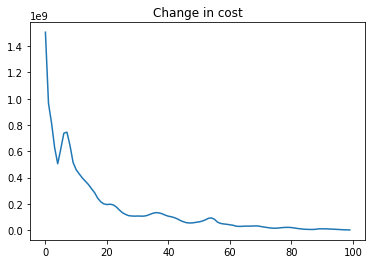

In [131]:
plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.show()

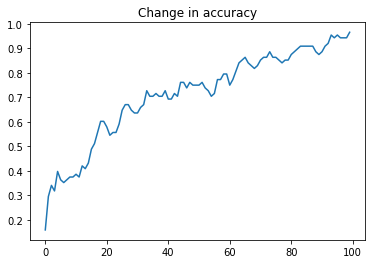

In [132]:
plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.show()

# Prediction on Test data

In [133]:
X1 = tf.placeholder(tf.float32, shape = [None, inputs]) # Placeholder for Feature Matrix
Y2 = tf.placeholder(tf.float32, shape = [None, classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) 

In [134]:
y_pred = neural_network(X1, W, B, 1.0)

In [147]:
def get_prediction(img):
    with tf.Session() as sess:
        pred = sess.run(y_pred, feed_dict = { X1 : img, keep_prob : 1.0 })
    img = img.reshape(28, 28)
    pred = list(pred.flatten())
    pred = pred.index(max(pred))*20
    return (img, pred)

In [166]:
image, pred = get_prediction(test_x[0].reshape(1, 784))

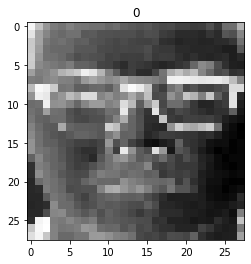

In [167]:
plt.imshow(image, cmap = 'binary')
plt.title(pred)
plt.show()

In [168]:
for key in W.keys():
    np.save(key, W[key])
for key in B.keys():
    np.save(key, B[key])

In [176]:
print(W)

{'w1': array([[[[ 0.5419448 , -0.06234519,  0.81102365, -0.00821169,
           0.64206   ,  0.52608544,  0.7342372 ,  0.72285616,
           1.7785275 ,  0.14514464, -1.9698743 , -0.2781484 ,
           2.674337  , -0.30430868,  1.7450312 ,  2.3077078 ,
           0.73143417,  0.7391997 ,  0.08766829, -0.26870215,
          -0.34055346, -0.21637782,  1.5258788 , -0.6202105 ,
          -0.5388997 , -1.6303482 , -0.3464579 , -0.7115592 ,
          -0.04554344,  1.2763867 ,  1.1401339 , -0.43071878]],

        [[-0.39058703, -1.0319443 ,  0.12645039,  1.3262942 ,
          -0.12666067,  2.0597334 ,  0.6199068 ,  0.31515366,
           0.20339333, -1.5297956 ,  0.6213036 , -0.6615681 ,
           1.8827772 , -0.2837989 , -0.37707517, -0.12160387,
           0.36647812, -0.96362585, -0.08965766, -0.83318114,
          -0.76067907, -0.21420206, -0.2575925 , -0.92490673,
           0.26006657, -0.58961874, -1.1079595 , -1.8938445 ,
          -2.0325263 ,  0.9497856 ,  0.31406432,  0.45180938

In [188]:
aaaa = {
    'w1' : np.array(np.load('w1.npy'),dtype=np.float32),
    'w2' : np.array(np.load('w2.npy'),dtype=np.float32),
    'w3' : np.array(np.load('w3.npy'),dtype=np.float32),
    'w4' : np.array(np.load('w4.npy'),dtype=np.float32)
}

In [189]:
print(aaaa)

{'w1': array([[[[ 0.5419448 , -0.06234519,  0.81102365, -0.00821169,
           0.64206   ,  0.52608544,  0.7342372 ,  0.72285616,
           1.7785275 ,  0.14514464, -1.9698743 , -0.2781484 ,
           2.674337  , -0.30430868,  1.7450312 ,  2.3077078 ,
           0.73143417,  0.7391997 ,  0.08766829, -0.26870215,
          -0.34055346, -0.21637782,  1.5258788 , -0.6202105 ,
          -0.5388997 , -1.6303482 , -0.3464579 , -0.7115592 ,
          -0.04554344,  1.2763867 ,  1.1401339 , -0.43071878]],

        [[-0.39058703, -1.0319443 ,  0.12645039,  1.3262942 ,
          -0.12666067,  2.0597334 ,  0.6199068 ,  0.31515366,
           0.20339333, -1.5297956 ,  0.6213036 , -0.6615681 ,
           1.8827772 , -0.2837989 , -0.37707517, -0.12160387,
           0.36647812, -0.96362585, -0.08965766, -0.83318114,
          -0.76067907, -0.21420206, -0.2575925 , -0.92490673,
           0.26006657, -0.58961874, -1.1079595 , -1.8938445 ,
          -2.0325263 ,  0.9497856 ,  0.31406432,  0.45180938

In [184]:
print(W)

{'w1': array([[[[ 0.5419448 , -0.06234519,  0.81102365, -0.00821169,
           0.64206   ,  0.52608544,  0.7342372 ,  0.72285616,
           1.7785275 ,  0.14514464, -1.9698743 , -0.2781484 ,
           2.674337  , -0.30430868,  1.7450312 ,  2.3077078 ,
           0.73143417,  0.7391997 ,  0.08766829, -0.26870215,
          -0.34055346, -0.21637782,  1.5258788 , -0.6202105 ,
          -0.5388997 , -1.6303482 , -0.3464579 , -0.7115592 ,
          -0.04554344,  1.2763867 ,  1.1401339 , -0.43071878]],

        [[-0.39058703, -1.0319443 ,  0.12645039,  1.3262942 ,
          -0.12666067,  2.0597334 ,  0.6199068 ,  0.31515366,
           0.20339333, -1.5297956 ,  0.6213036 , -0.6615681 ,
           1.8827772 , -0.2837989 , -0.37707517, -0.12160387,
           0.36647812, -0.96362585, -0.08965766, -0.83318114,
          -0.76067907, -0.21420206, -0.2575925 , -0.92490673,
           0.26006657, -0.58961874, -1.1079595 , -1.8938445 ,
          -2.0325263 ,  0.9497856 ,  0.31406432,  0.45180938